# MANTIS Modeling and Prediction

**AI-Based Equipment Failure Classification and Spare Demand Forecasting**

This notebook trains two core models:
1. Equipment Failure Classifier using Random Forest
2. Spare Part Demand Forecast using XGBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from xgboost import XGBRegressor
sns.set(style='whitegrid')

## 1. Equipment Failure Prediction – Random Forest

c:\Users\nagan\OneDrive\Desktop\Mantis\app\mantis-env\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:17:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔎 Best PR-F1 threshold = 0.654,  F1 = 0.316,  Recall = 0.500

📊 Classification Report @ threshold 0.654469556824581
              precision    recall  f1-score   support

           0      0.966     0.894     0.928        94
           1      0.231     0.500     0.316         6

    accuracy                          0.870       100
   macro avg      0.598     0.697     0.622       100
weighted avg      0.921     0.870     0.891       100

🔍 ROC AUC Score: 0.637


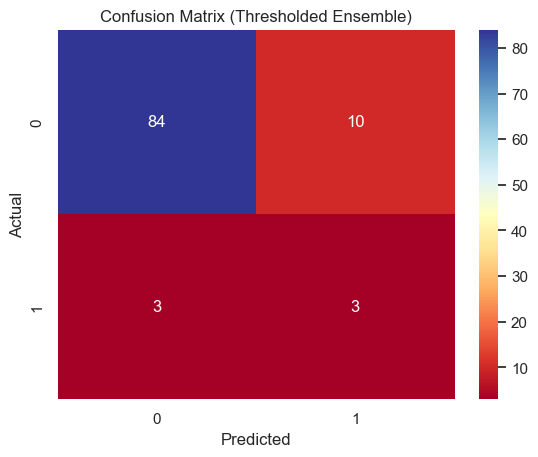

['C:\\Users\\nagan\\OneDrive\\Desktop\\Mantis\\models\\equipment_failure_model.pkl']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve)
from imblearn.over_sampling import BorderlineSMOTE

sns.set(style='whitegrid')

# 1) Load & split
df = pd.read_csv(r"C:\Users\nagan\OneDrive\Desktop\Mantis\data\equipment_logs.csv")
X = df[['Uptime_Hours', 'Environment_Stress', 'Temperature']]
y = df['Failure']
X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# 2) Borderline-SMOTE oversample
bl_smote = BorderlineSMOTE(random_state=42)
X_res, y_res = bl_smote.fit_resample(X_tr, y_tr)

# 3) Build base classifiers
rf  = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=5,
                    scale_pos_weight=(y_res==0).sum()/(y_res==1).sum(),
                    use_label_encoder=False, eval_metric='logloss', random_state=42)
lr  = LogisticRegression(class_weight='balanced', max_iter=1000)

# 4) Ensemble with soft voting
ensemble = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb), ('lr', lr)],
    voting='soft',           # so we can tune threshold
    weights=[2,3,1]          # give a bit more weight to xgb
)
ensemble.fit(X_res, y_res)

# 5) Get predicted probabilities
probs = ensemble.predict_proba(X_te)[:,1]

# 6) Find best threshold on precision-recall curve
prec, rec, thr = precision_recall_curve(y_te, probs)
f1_scores = 2*prec*rec/(prec+rec+1e-9)
best = np.argmax(f1_scores)
best_thr = thr[best]
print(f"🔎 Best PR-F1 threshold = {best_thr:.3f},  F1 = {f1_scores[best]:.3f},  Recall = {rec[best]:.3f}")

# 7) Final predictions with tuned threshold
y_pred = (probs >= best_thr).astype(int)

# 8) Final Evaluation
print("\n📊 Classification Report @ threshold", best_thr)
print(classification_report(y_te, y_pred, digits=3))
print("🔍 ROC AUC Score:", round(roc_auc_score(y_te, probs),3))

# 9) Confusion matrix plot
sns.heatmap(confusion_matrix(y_te, y_pred), annot=True, fmt='d', cmap='RdYlBu')
plt.title("Confusion Matrix (Thresholded Ensemble)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

# 10) Save
joblib.dump(ensemble, r"C:\Users\nagan\OneDrive\Desktop\Mantis\models\equipment_failure_model.pkl")


## 2. Spare Part Demand Forecast – XGBoost Regressor

RMSE: 0.61
R² Score: 0.94


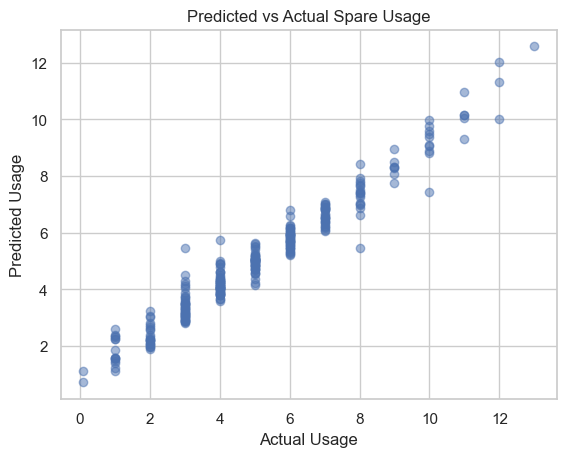

['C:\\Users\\nagan\\OneDrive\\Desktop\\Mantis\\models\\spare_demand_model.pkl']

In [3]:
# Load Spare Inventory Data
spares = pd.read_csv(r"C:\Users\nagan\OneDrive\Desktop\Mantis\data\spare_inventory.csv")

# Define Features & Target
X_spare = spares[['Criticality_Score', 'Lead_Time_Days', 'Current_Stock']]
y_spare = spares['Daily_Use_Rate']

# Train XGBoost Regressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_spare, y_spare)

# Predict and Evaluate
y_pred_spare = xgb.predict(X_spare)
rmse = np.sqrt(mean_squared_error(y_spare, y_pred_spare))
r2 = r2_score(y_spare, y_pred_spare)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Scatter Plot
plt.scatter(y_spare, y_pred_spare, alpha=0.5)
plt.xlabel("Actual Usage")
plt.ylabel("Predicted Usage")
plt.title("Predicted vs Actual Spare Usage")
plt.show()

# Save Model
joblib.dump(xgb, r"C:\Users\nagan\OneDrive\Desktop\Mantis\models\spare_demand_model.pkl")